In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

import json

### Load in data

+ Load in data. `aaindex-data.json` is the entire aaindex database in a standard json format.
+ Replace any "NA" with the mean value for that feature (after standardization, this will be zero)
+ Standardize features so their mean is 0 and their standard deviation is 1.

After this cell is run, `data` will be an $566 \times 20$ array, where each row is a standardized feature from the `aaindex` and each column is an amino acid

In [2]:
json_data = json.load(open("aaindex-data.json"))

# Figure out what features are in the array
features = list(json_data.keys())
features.sort()

# Get all amino acids
amino_acids = list(json_data[list(json_data.keys())[0]]["values"].keys())
amino_acids.sort()

# Data will bye a num_feature x num_aa array with standardized features
data = np.zeros((len(features),len(amino_acids)),dtype=float)

for i, f in enumerate(features):
     
    # Get values
    values = [json_data[f]["values"][aa] for aa in amino_acids]
    
    # Turn to float, converting "NA" to nan
    out = []
    for v in values:
        try:
            out.append(float(v))
        except ValueError:
            out.append(np.nan)

    # Replace nan with the mean value for the vector.
    out = np.array(out)
    
    na_mask = np.isnan(out)
    not_na_mask = np.array(1-na_mask,dtype=bool)
    
    mean_value = np.mean(out[not_na_mask])
    out[na_mask] = mean_value

    # Standardize data so mean is zero and standard deviation is -1 to 1
    out = out - np.mean(out)
    out = out/np.std(out)
    
    # Record data
    data[i,:] = out
    

### Perform the PCA and transform the original data on to the PCA axes

0.341
0.157
0.118
0.068
0.054
0.048
0.034
0.026
0.023
0.021
0.019
0.018
0.015
0.012
0.011
0.011
0.010
0.008
0.007
0.000


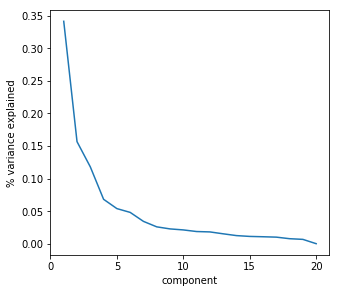

In [3]:
# do the PCA
pca = PCA()
data_pca = pca.fit(data)

# Plot the distribution of the explained variance across the components
for r in data_pca.explained_variance_ratio_:
    print("{:.3f}".format(r))

plt.figure(figsize=(5,4.5))
plt.plot(range(1,21),data_pca.explained_variance_ratio_)

plt.xlim((0,21))
plt.xlabel("component")
plt.xticks((0,5,10,15,20))
plt.ylabel("% variance explained")

### Write out final pca json file

In [ ]:
all_out = {}

for i in range(20):
    
    key = "aaindex_pca_{}".format(i+1)
    all_out[key] = {}
    all_out[key]["description"] = "aaindex principle component analysis, component {}".format(i+1)
    all_out[key]["notes"] = ""
    all_out[key]["refs"] = ""
    all_out[key]["values"] = {}
    
    for j in range(20):
        all_out[key]["values"][amino_acids[j]] = data_pca.components_[i,j]
        
f = open("aaindex-pca.json","w")
json.dump(all_out,f,indent=4,sort_keys=True)
f.close()

### Determine the fractional contribution of each original feature to each PCA

`fx_component` will hold the relative contribution of each aaindex feature to the principle component

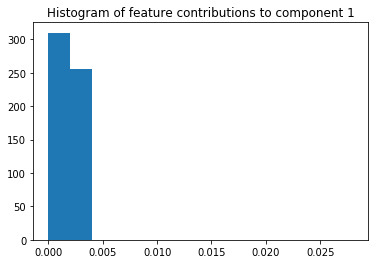

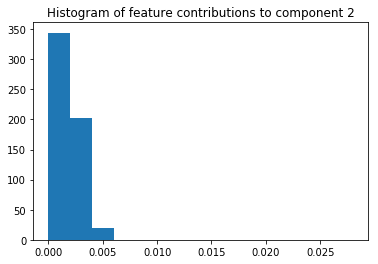

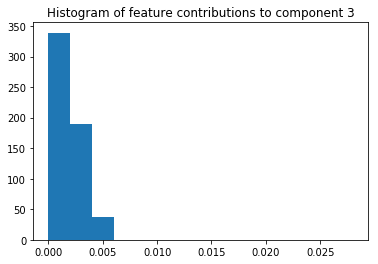

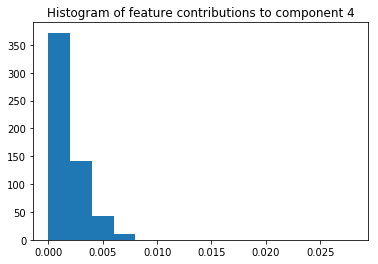

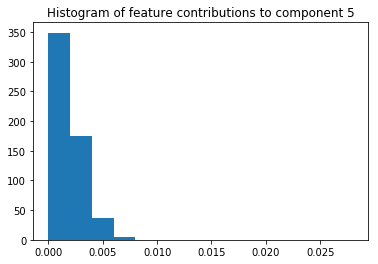

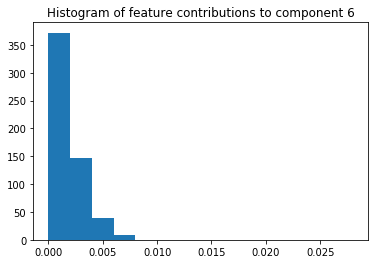

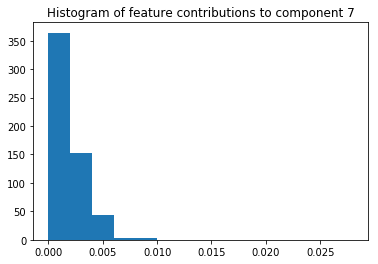

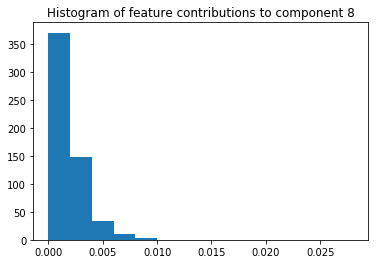

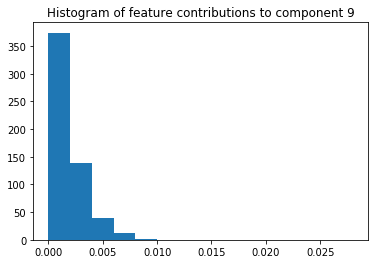

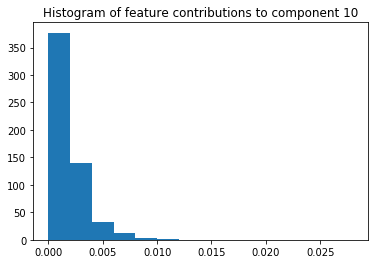

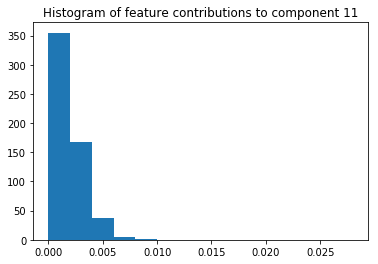

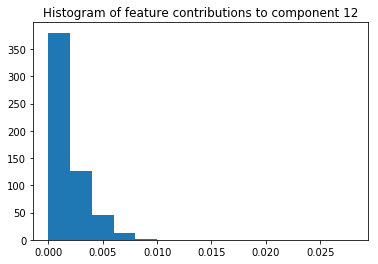

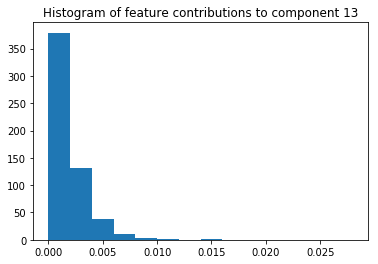

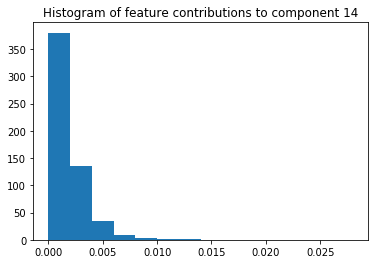

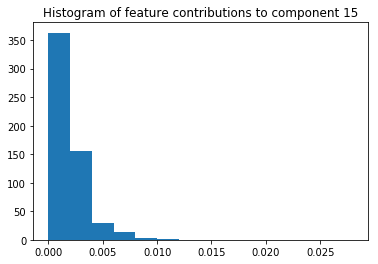

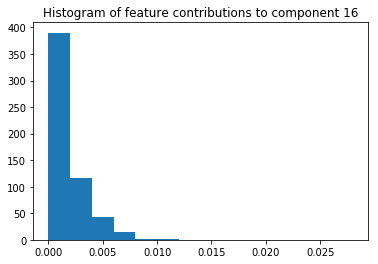

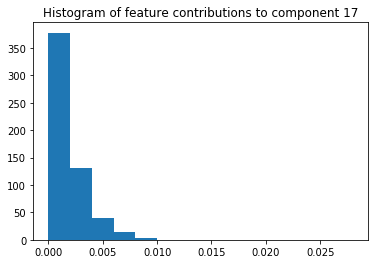

In [ ]:
# Transform the original n_features x num_amino acids matrix with the pca
data_trans = data_pca.transform(data)

# Find the fractional contribution of each of the original features to each 
# pca component
abs_component = np.abs(data_trans)
fx_component = np.copy(abs_component)
for i in range(abs_component.shape[1]):
    total_length = np.sum(abs_component[:,i])
    fx_component[:,i] = abs_component[:,i]/np.sum(abs_component[:,i])
    
# Plot a histogram of the relative contributions of each original feature 
# to the pca components
for i in range(fx_component.shape[1]):
    a = plt.hist(fx_component[:,i],bins=np.arange(0,0.03,0.002))
    plt.title("Histogram of feature contributions to component {}".format(i+1))
    plt.show()


# Map features to categories

### Map the aaindex PCA components back to categories

`aaindex-to-category.txt` is a text file which indicates that category for each aaindex feature. 

In [ ]:
# Read the category of each feature
f = open("aaindex-to-category.txt")
lines = [l for l in f.readlines() if l.strip() != "" and l[0] != "#"]
f.close()

# create dictionary mapping aaindex feature to category
categories = {}
for l in lines:
    col = l.split()
    categories[col[0]] = col[1]

# Create a list of all categories
possible_categories = list(set(list(categories.values())))
possible_categories.sort()

# Go through every PCA component
component_categories = []
for i in range(fx_component.shape[1]):
    
    # For each component, contributing_categories will store the fractional 
    # contribution of each category
    contributing_categories = {k:0.0 for k in possible_categories}
    
    # Figure out the category of every aaindex feature.  Add its fractional
    # contribution to the feature dict
    for j, e in enumerate(features):
        cat = categories[e]
        contributing_categories[cat] += fx_component[j,i]
        
    component_categories.append(contributing_categories)
    
# Create output and write to file
out = []
out.append("{:36s}".format("feature"))
for k in possible_categories:
    out.append("{:>14s}".format(k))
out.append("\n")

for i, c in enumerate(component_categories):
    
    out.append("{:36s}".format("aaindex_pca_{}".format(i+1)))
    for k in possible_categories:
        out.append("{:14.5e}".format(c[k]))
    out.append("\n")
    
f = open("feature-to-category.txt","w")
f.write("".join(out))
f.close()


### Now append other features classes to the feature file

`basic_features` is my classification of the non-aainded features.  These categories will be appended to the end of `feature-to-cateogry.txt`.

In [ ]:
basic_features = {"geometry":  ["knob_mc_b",
                                "knob_sc_b",
                                "socket_mc_x",
                                "socket_sc_y",
                                "socket_sc_x",
                                "socket_mc_h",
                                "socket_sc_h",
                                "socket_mc_y",
                                "volume",
                                "mw",
                                "cider_molecular_weight",
                                "aromatic"],
                "flexibility": ["dS_buex",
                                "dS_exu",
                                "dS_bb",
                                "cider_fraction_disorder_promoting"],
                "sec_struct":  ["cf_beta",
                                "cf_alpha",
                                "cf_turn",
                                "cider_FPPII_chain"],
                "hydrophobic": ["cider_meanHydropathy", 
                                "white_interface",
                                "engleman",
                                "pct_buried",
                                "kyte_dootlittle",
                                "white_octanol",
                                "hopp_woods",
                                "cider_uverskyHydropathy",
                                "cider_cumMeanHydropathy",
                                "asa_sidechain_nonpolar",
                                "asa_mainchain"],
                "polar":       ["asa_sidechain_polar",
                                "num_acceptors",
                                "num_donors",
                                "charge",
                                "cider_kappa",
                                "cider_isoelectric_point",
                                "cider_delta",
                                "cider_charge_at_pH9",
                                "cider_charge_at_pH4",
                                "cider_Omega",
                                "cider_FER",
                                "cider_sigma",
                                "cider_mean_net_charge",
                                "cider_dmax",
                                "cider_deltaMax",
                                "cider_countPos",
                                "cider_countNeut",
                                "cider_countNeg",
                                "cider_charge_at_pH8",
                                "cider_charge_at_pH7",
                                "cider_charge_at_pH6",
                                "cider_charge_at_pH5",
                                "cider_NCPR",
                                "cider_Fplus",
                                "cider_Fminus",
                                "cider_FCR"]
                  }


# Construct a list of feature 
feature_list = []
basic_categories = []
for b in basic_features.keys():
    for feature in basic_features[b]:
        
        feature_list.append(feature)
        
        contributing_categories = {k:0.0 for k in possible_categories}
        contributing_categories[b] = 1.0
        basic_categories.append(contributing_categories)

        

out = []
for i, c in enumerate(basic_categories):
    
    out.append("{:36s}".format(feature_list[i]))
    for k in possible_categories:
        out.append("{:14.5e}".format(c[k]))
    out.append("\n")
                   
f = open("feature-to-category.txt","a")
f.write("".join(out))
f.close()
    